<a href="https://colab.research.google.com/github/valsson-group/UNT-Chem5660-Fall2023/blob/main/Python-JupyterNotebooks/Assignment4_Create_Reactant_from_InChI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMILES and InChl Molecular Representations



# Imports and Function Definitions

In [1]:
%%capture
!pip install rdkit
!pip install py3Dmol
!pip install ipywidgets

In [2]:
# RDKit imports:
from rdkit import Chem
from rdkit.Chem import (
    AllChem,
    rdCoordGen,
)
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True

import py3Dmol

In [3]:
def get_xyz(molecule, optimize=False):
    """Get xyz-coordinates for the molecule"""
    mol = Chem.Mol(molecule)
    mol = AllChem.AddHs(mol, addCoords=True)
    AllChem.EmbedMolecule(mol)
    if optimize:  # Optimize the molecules with the MM force field:
        AllChem.MMFFOptimizeMolecule(mol)
    xyz = []
    for lines in Chem.MolToXYZBlock(mol).split("\n")[2:]:
        strip = lines.strip()
        if strip:
            xyz.append(strip)
    xyz = "\n".join(xyz)
    return mol, xyz

# Molecule from SMILES String

### Define SMILES String for Molecule



In [22]:
molecule_smiles = "C(=CC#N)C#N"


## Do All Calculations

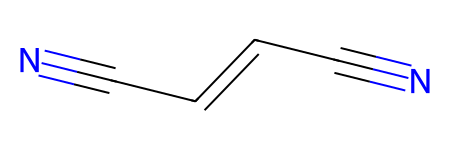

In [23]:
molecule = Chem.MolFromSmiles(molecule_smiles)
molecule

### Get XYZ Cartesian Coordinates

In [24]:
molecule3d, xyz = get_xyz(molecule, optimize=True)
print(xyz)

C      0.519129   -0.198320    0.696035
C     -0.704289    0.294903    0.458584
C     -1.250400    0.493120   -0.838655
N     -1.715945    0.663173   -1.886029
C      1.435774   -0.589815   -0.317300
N      2.198998   -0.915144   -1.126185
H      0.857312   -0.316999    1.720068
H     -1.340579    0.569082    1.293484


### Visualize 3D Molecular Structure

In [25]:
view = py3Dmol.view(
    data=Chem.MolToMolBlock(molecule3d),
    style={"stick": {}, "sphere": {"scale": 0.3}},
    width=600,
    height=600,
)
view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Molecule from InChi String

### Define InChi String for Molecule

In [26]:
molecule_Inchi = "InChI=1S/C4H2N2/c5-3-1-2-4-6/h1-2H"


## Do All Calculations

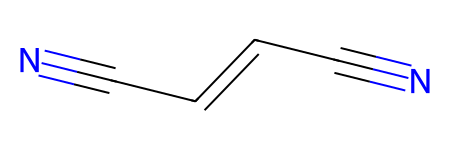

In [27]:
molecule = Chem.MolFromInchi(molecule_Inchi)
molecule

### Get XYZ Cartesian Coordinates

In [29]:
molecule3d, xyz = get_xyz(molecule, optimize=True)
print(xyz)

C      0.166041    0.622896   -0.182460
C     -0.166043   -0.622896    0.182460
C     -0.648816    1.381764   -1.062294
C      0.648817   -1.381764    1.062293
N     -1.321716    1.992504   -1.781445
N      1.321718   -1.992501    1.781445
H      1.071792    1.097353    0.182333
H     -1.071793   -1.097356   -0.182331


### Visualize 3D Molecular Structure

In [30]:
view = py3Dmol.view(
    data=Chem.MolToMolBlock(molecule3d),
    style={"stick": {}, "sphere": {"scale": 0.3}},
    width=600,
    height=600,
)
view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol